In [1]:
import geopandas as gpd 
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt

# Tool Outputting Zillow County Data Shapefile from CSV Input
I suggest cleaning the Zillow data before loading it in to the code. Also, it will be easier to select your specific regions of interest from the output of this code than doing each individually before joining. The join column has small discontinuities which this code handles, for example: Dewitt County vs De Witt County. Overall, I believe Zillow is missing a few counties and the counties shapefile misses Valdez Cordova in Alaska.

Make sure to have all packages installed and personalise to your file paths. Some commented lines are provided for viewing the data, uncomment as needed.

## Input Data
These both include all US counties. Use these datasets for most complete pairing results. 

### Zillow Data:
Choose desired data type and download for county geography: https://www.zillow.com/research/data/  
ZHVI All homes smoothed and seasonally adjusted is most popular.

### Counties Shapefile
2021 TIGER/line all US counties: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-nation-u-s-counties-and-equivalent-entities

In [2]:
## Zillow load in (change input path)
Zillowpath = ('/your/zillowcsv/path/here/countyzillow.csv') # Remove or average months you want in excel prior to loading in
zillowcounty = pd.read_csv(Zillowpath)
zillowcounty.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,2000-01-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,3101,0,Los Angeles County,county,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",6,37,208647.919509,...,865153.204373,864132.886760,859326.994934,855511.376681,856150.753342,859330.357288,861428.532750,865092.978391,870313.709819,876958.430862
1,139,1,Cook County,county,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",17,31,147507.033889,...,295574.379458,295807.192380,296750.247771,298765.785128,301413.876693,303248.683214,304304.208302,304962.575753,305787.824375,306458.976441
2,1090,2,Harris County,county,TX,TX,"Houston-The Woodlands-Sugar Land, TX",48,201,109138.965088,...,279592.471752,279703.229912,280164.028963,281162.470003,282201.612312,282791.048604,282673.306736,282304.781165,281966.974553,281752.789691
3,2402,3,Maricopa County,county,AZ,AZ,"Phoenix-Mesa-Chandler, AZ",4,13,143468.389801,...,465560.641583,465924.628213,466463.367772,467916.658718,469691.605770,471094.123500,471262.762845,470658.091259,469541.963287,468595.683794
4,2841,4,San Diego County,county,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",6,73,214455.519985,...,902390.480071,904658.344283,909191.241655,917402.267397,927651.265767,936425.664757,940920.734698,942366.615764,941928.201959,941480.058616


In [3]:
## Counties load in and plot (change input path)
CountySHPpath = ('your/countyshapefile/path/here/tl_2021_us_county.shp') 
countyshp = gpd.read_file(CountySHPpath)

countyshp.head()

## Plot (uncomment lines below and run cell to view)
#countyshp.plot(figsize=(10, 10), edgecolor='black')
#plt.title('US Counties and Territories')
#plt.show()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55516 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.38368 34.69213, -104.37658 34.6..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169272970,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.6814 41.04566, -96.68139 41.0456..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.04802 40.35066, -98.04674 40.350..."


In [4]:
## Cleaning the join columns and merging datasets
def clean_string(text):
    if pd.isnull(text):  
        return text
    # Normalize to remove diacritics
    text = unicodedata.normalize('NFKD', text)
    text = ''.join(char for char in text if not unicodedata.combining(char))
    # Convert to lowercase and remove spaces and special characters
    text = text.lower().replace(" ", "").replace("'", "").replace("-", "")
    return text

countyshp['STATEFP'] = countyshp['STATEFP'].astype(int)
zillowcounty['StateCodeFIPS'] = zillowcounty['StateCodeFIPS'].astype(int)
zillowcounty.rename(columns={'StateCodeFIPS': 'StateFIPS'}, inplace=True)
## County dataset matching specific instances to zillow dataset
countyshp['NAMELSAD'] = countyshp['NAMELSAD'].str.replace('St.', 'Saint').str.replace('Ste.', 'Sainte')
countyshp['NAMELSAD'] = countyshp['NAMELSAD'].replace("Anchorage Municipality", "Anchorage Borough")
countyshp['NAMELSAD'] = countyshp['NAMELSAD'].replace("Southeast Fairbanks Census Area", "Southeast Fairbanks Borough")
## Apply the cleaning function and final fixes
countyshp['NAMELSAD'] = countyshp['NAMELSAD'].apply(clean_string)
countyshp['NAMELSAD'] = countyshp['NAMELSAD'].str.replace('cityand', '', regex=False)
zillowcounty['CountyName'] = zillowcounty['RegionName']
zillowcounty['CountyName'] = zillowcounty['CountyName'].apply(clean_string)
## Create a combined key for the join
countyshp['JoinKey'] = countyshp['NAMELSAD'] + countyshp['STATEFP'].astype(str)
zillowcounty['JoinKey'] = zillowcounty['CountyName'] + zillowcounty['StateFIPS'].astype(str)

## Join and check
merged_df = zillowcounty.merge(
    countyshp,
    on='JoinKey',
    how='outer',
    indicator=True
)
# Check rows that didn't join from zillowcounty
unmatched_zillow = merged_df[merged_df['_merge'] == 'left_only'] # Valdez Cordova (Alaska) is expected, not in shapefile dataset
print("Unmatched rows from Zillow dataset:")
print(unmatched_zillow[['RegionName', 'StateFIPS']])
# Check rows that didn't join from countyshp
unmatched_county = merged_df[merged_df['_merge'] == 'right_only'] # 161 extras are expected, shapefile dataset includes some things Zillow doesn't
print("\nUnmatched rows from countyshp dataset:")
print(unmatched_county[['NAMELSAD', 'STATEFP']])

Unmatched rows from Zillow dataset:
                  RegionName  StateFIPS
2960  Valdez Cordova Borough        2.0

Unmatched rows from countyshp dataset:
                    NAMELSAD  STATEFP
21         adjuntasmunicipio     72.0
22           aguadamunicipio     72.0
23        aguadillamunicipio     72.0
24      aguasbuenasmunicipio     72.0
25         aibonitomunicipio     72.0
...                      ...      ...
3205        yabucoamunicipio     72.0
3208          yakutatborough      2.0
3214          yaucomunicipio     72.0
3229  yukonkoyukukcensusarea      2.0
3234           ziebachcounty     46.0

[161 rows x 2 columns]


In [5]:
## OPTIONAL Export unmatched rows to CSV for better understanding 
unmatched_zillow_path = '/your/export/path/here/unmatched_zillow.csv'
unmatched_county_path = '/your/export/path/here/unmatched_county.csv'

## Uncomment below and run cell to save CSV to above the path
#unmatched_zillow[['CountyName', 'StateFIPS']].to_csv(unmatched_zillow_path, index=False)
#unmatched_county[['NAMELSAD', 'STATEFP']].to_csv(unmatched_county_path, index=False)

In [6]:
## Clean merged dataset
zillowshp = merged_df[merged_df['_merge'] == 'both']

## Removing unnecessary columns, feel free to add or subtract to this list (don't remove JoinKey)
zillowshp = zillowshp.drop(columns=['_merge', 'CountyName', 'STATEFP', 'RegionType', 'RegionID', 'Metro', 'MunicipalCodeFIPS','COUNTYNS', 'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'ALAND', 'AWATER', 'StateName', 'FUNCSTAT', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP'])
zillowshp = gpd.GeoDataFrame(zillowshp, geometry='geometry')
zillowshp.set_crs(countyshp.crs, inplace=True)

print("Shape of zillowshp DataFrame:", zillowshp.shape)
zillowshp.head()

Shape of zillowshp DataFrame: (3073, 307)


,SizeRank,RegionName,State,StateFIPS,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,JoinKey,COUNTYFP,GEOID,INTPTLAT,INTPTLON,geometry
0,1677.0,Abbeville County,SC,45.0,55500.239134,55453.449602,55268.243727,54851.34242,54452.908647,54190.474604,...,196678.997236,197029.316777,197617.205436,197775.474817,abbevillecounty45,001,45001,+34.2290410,-082.4540577,"POLYGON ((-82.50085 34.0719, -82.50093 34.0719..."
1,906.0,Acadia Parish,LA,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,144694.389175,144313.317156,144113.514205,143231.764425,acadiaparish22,001,22001,+30.2914970,-092.4110366,"POLYGON ((-92.3615 30.07855, -92.36294 30.0777..."
2,1376.0,Accomack County,VA,51.0,NaN,NaN,NaN,NaN,NaN,NaN,...,240106.268317,240438.915933,240719.287423,241286.358766,accomackcounty51,001,51001,+37.7659435,-075.7578073,"POLYGON ((-75.51692 37.65483, -75.5172 37.6533..."
3,146.0,Ada County,ID,16.0,NaN,NaN,NaN,NaN,NaN,NaN,...,503694.492921,504167.720415,504952.384554,506205.664492,adacounty16,001,16001,+43.4514767,-116.2443760,"POLYGON ((-115.98028 43.58595, -115.98018 43.5..."
4,2703.0,Adair County,IA,19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,174425.284539,175014.280448,174840.454948,174488.540020,adaircounty19,001,19001,+41.3285283,-094.4781643,"POLYGON ((-94.2417 41.24374, -94.24161 41.2254..."


## Optional filtering for states to include or exclude toward output Shapefile

In [7]:
## Uncomment the relevant lines to include or exclude states for final output, or leave both commented for no action

#states_to_include = ['CA', 'NY', 'TX']  # Replace with your desired states to include
## Uncomment line below to only output included states
#zillowshp = zillowshp[zillowshp['State'].isin(states_to_include)]

#states_to_exclude = ['CA', 'NY', 'TX']  # Replace with your desired states to exclude
## Uncomment line below to output all but excluded states
#zillowshp = zillowshp[~zillowshp['State'].isin(states_to_exclude)]

# Final Output Shapefile

In [8]:
## Output shapefile (change file path)
output_path = '/your/output/path/here/zillowcounty.shp'  # Replace with your desired path and filename
zillowshp.to_file(output_path, driver='ESRI Shapefile') # Remove years of month columns from Zillow dataset in excel to not get 256th field warning

## Check by Plotting (w optional save as SVG)

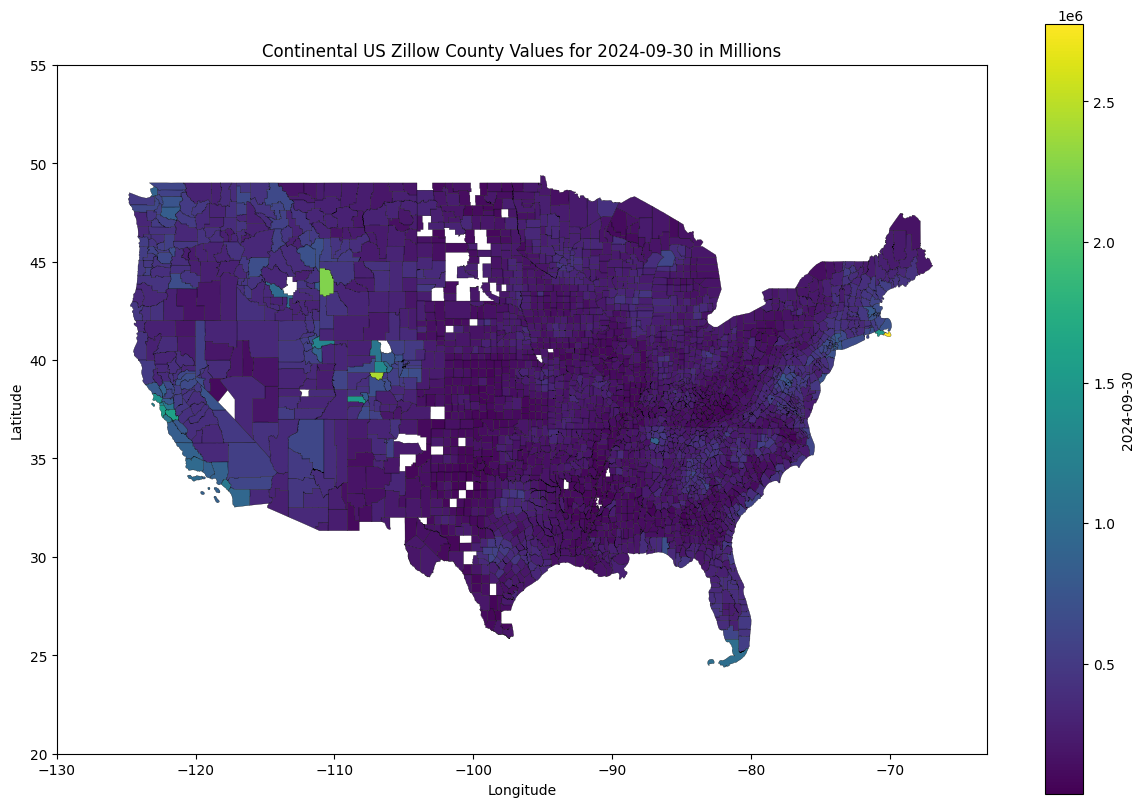

In [9]:
# Plot by Value
countyfp_index = zillowshp.columns.get_loc('JoinKey') 
plot_column = zillowshp.columns[countyfp_index - 1]  # Plot based on last column from zillow csv (one column before JoinKey) Change as need be.

fig1, ax = plt.subplots(figsize=(15, 10))
plot1 = zillowshp.plot(
    ax=ax,
    column=plot_column,
    edgecolor='black',
    linewidth=0.2,
    cmap='viridis',
)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=zillowshp[plot_column].min(), vmax=zillowshp[plot_column].max()))
sm._A = []  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(f"{plot_column}")

ax.set_title(f'Continental US Zillow County Values for {plot_column} in Millions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(left=-130, right=-63)  # cut to include only continental US
ax.set_ylim(bottom=20, top=55) 

## Uncomment line below for Optional figure download
#plt.savefig('your/export/file/path/ZillowbyValue.svg', format='svg', dpi=300, bbox_inches='tight') #update to your file path and desired file type

plt.show()

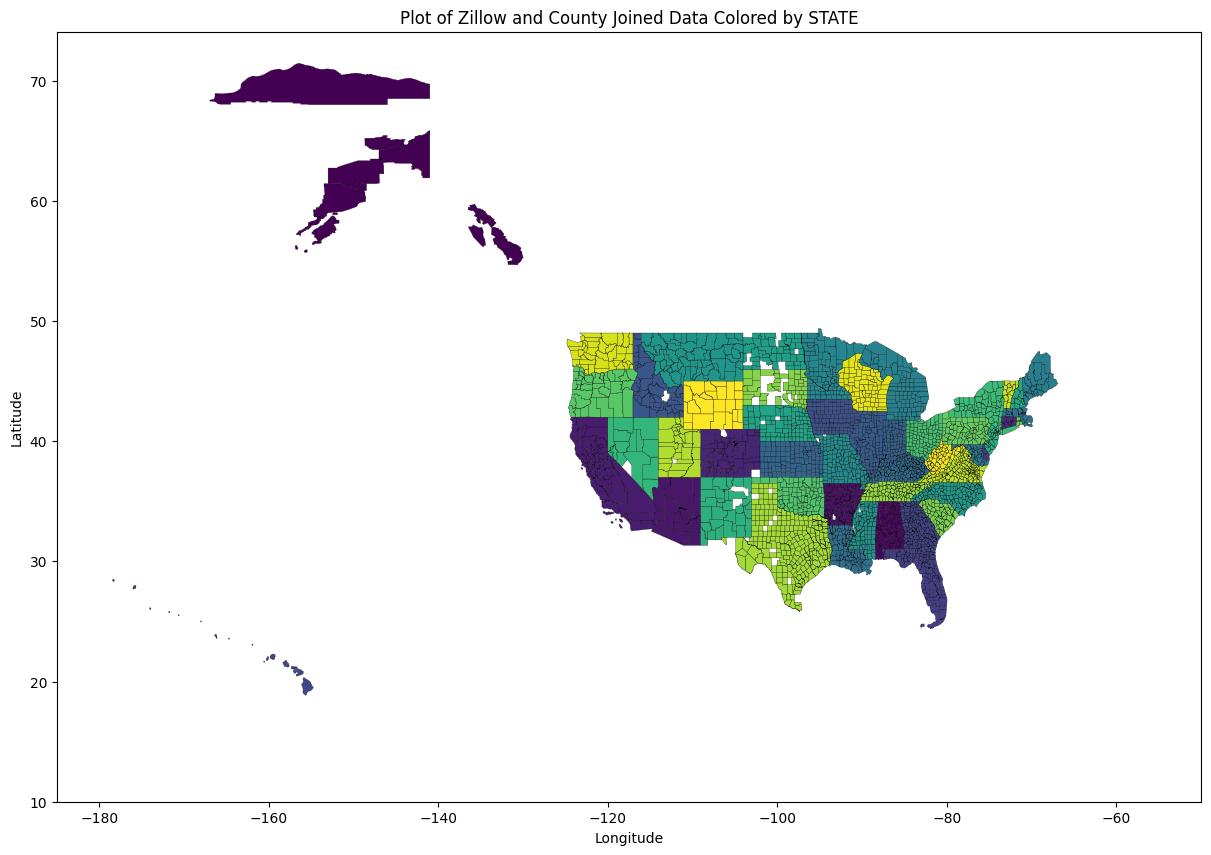

In [10]:
# Plot counties by state to check geometry
fig2, ax = plt.subplots(figsize=(15, 10))
plot2 = zillowshp.plot(
    ax=ax,
    column='State',  # Plot using the 'State' column
    edgecolor='black',
    linewidth=0.2,
    cmap='viridis',
    legend=False
)

ax.set_title('Plot of Zillow and County Joined Data Colored by STATE')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(left=-185, right=-50)  # Cut to exclude some territories
ax.set_ylim(bottom=10)  

## Uncomment line below for Optional figure download
#plt.savefig('your/export/file/path/ZillowbyState.svg', format='svg', dpi=300, bbox_inches='tight') #update to your file path and desired file type

plt.show()